In [27]:
# Core imports and lightweight VoidX import
import voidx  # lightweight package import
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import json
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, average_precision_score, precision_score, recall_score, roc_auc_score
from sklearn.calibration import calibration_curve
from numpy.lib.format import open_memmap
from pathlib import Path
from glob import glob
import os
from torch.nn import BCEWithLogitsLoss

from voidx.models import TinyCNN, DeepResidualCNN

from voidx.data import GalaxyDataset, split_indices, split_indices_stratified
from voidx.losses import FocalLossWithLogits, BCEWithLogitsWithLabelSmoothing
from voidx.utils import evaluate_model
from voidx.plot import (
    plot_precision_recall_curve,
    plot_prediction_distribution,
    plot_threshold_analysis,
    register_activation_hooks, 
    visualize_feature_maps, 
    plot_first_global_embedding, 
    expected_calibration_error, 
    plot_reliability_diagram, 
    plot_training_and_validation_loss, 
    plot_confusion_matrices_all_views,
    plot_confusion_matrix_basic, 
    plot_roc_curve,
    true_false_positive_negative
)

# Configuration

In [28]:
from voidx.config import get_config

config = get_config(name='simulation_box2', param=None)  # picks up everything from config/global.json
# config = get_config(name='synthetic_void')  # picks up everything from config/global.json

# For backward compatibility, create variables from config
box = config.box
hdf = config.hdf
VIDE = config.VIDE
name = config.name
param = config.param
param_str = str(param) if param else 'default'

fraction_in_voids = config.fraction_in_voids
N_neighbours = config.N_neighbours
box_size_mpc = config.box_size_mpc
void_size = config.void_size
model_name = config.model_name
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
seed = config.seed

# Paths are automatically set up
data_dir = config.data_dir
param_dir = config.param_dir 
galaxy_info_dir = config.galaxy_info_dir
checkpoint_dir_spec = config.checkpoint_dir_spec
checkpoint_dir_global = config.checkpoint_dir_global
plot_dir = config.plot_dir
result_dir = config.result_dir

# Display configuration
config.print_info()

Loading global settings from /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/config/config_global.json
Using device: mps
Notebook Configuration
Dataset: simulation_box2
Model name: simulation_box2_
Fraction in voids: 
Box: True, HDF: False, VIDE: False
Device: mps, Seed: 42
N neighbours: 20
Box size (Mpc/h): 60.0
Void size: 3.0
------------------------------------------------------------
Paths:
  data_dir: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2
  param_dir: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default
  galaxy_info_dir: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/galaxy_info_files
  checkpoint_dir_spec: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/checkpoints
  checkpoint_dir_global: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/checkpoints
  plot_dir: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/s

# Reproducibility

In [29]:
if name == 'synthetic_void':

    knn_file = galaxy_info_dir / f'galaxy_knn_{param_str}.npz'
    print(f"Loading k-NN data from: {knn_file}")

    with np.load(knn_file, allow_pickle=True) as data:
        print("Available keys:", list(data.keys()))
        positions = data['positions']
        membership = data['membership']
        first_neighbor_distances = data['first_neighbor_distances'] if 'first_neighbor_distances' in data else None
        void_centers = data['void_centers'] if 'void_centers' in data else None


        tensor_file = galaxy_info_dir / f'tensor_distances_{param_str}.npz'
        if tensor_file.exists():
            print(f"Found tensor file at: {tensor_file}")
            tensor_distance = np.load(tensor_file, mmap_mode='r')
            print("Loaded tensor from memory-mapped NPZ file.")
        else:
            raise FileNotFoundError("Tensor distance memory-mapped file not found.")

else:

    knn_file = galaxy_info_dir / f'galaxy_knn_N{N_neighbours}.npz'
    print(f"Loading k-NN data from: {knn_file}")

    with np.load(knn_file, allow_pickle=True) as data:
        print("Available keys:", list(data.keys()))
        positions = data['positions']
        membership = data['membership']
        first_neighbor_distances = data['first_neighbor_distances'] if 'first_neighbor_distances' in data else None
        void_centers = data['void_centers'] if 'void_centers' in data else None
        tensor_distance = data['tensor_distance'] if 'tensor_distance' in data else None

print("positions:", positions.shape)
print("membership:", membership.shape)
print("tensor_distance:", tensor_distance.shape) if tensor_distance is not None else print("tensor_distance: None")
print("first_neighbor_distances:", first_neighbor_distances.shape)

num_galaxies = positions.shape[0]
print(f"Number of galaxies: {num_galaxies}")
print('Number of voids:', len(void_centers) if void_centers is not None else 'N/A')

# Coordinates for geometry-based steps
X = tensor_distance.astype(np.float32) if tensor_distance is not None else None
y = membership.astype(np.float32)

# seeded random subset to avoid ordering bias
np.random.seed(seed)
indices = np.random.permutation(len(X))
X = X[indices]
y = y[indices]

X = X[::10]
y = y[::10]

print(f'Shape of X : {X.shape}')
print(f'Shape of y : {y.shape}')

Loading k-NN data from: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/galaxy_info_files/galaxy_knn_N20.npz
Available keys: ['positions', 'membership', 'first_neighbor_distances', 'void_centers', 'tensor_distance']
positions: (374460, 3)
membership: (374460,)
tensor_distance: (374460, 20, 20)
first_neighbor_distances: (374460, 20)
Number of galaxies: 374460
Number of voids: 200
Shape of X : (37446, 20, 20)
Shape of y : (37446,)


# Split the data into training, validation, and test sets

In [30]:
train_idx, val_idx, test_idx = split_indices(len(X), train=0.7, val=0.15, seed=seed)
# train_idx, val_idx, test_idx = split_indices_stratified(y, train=0.7, val=0.15, seed=seed)

print("Train/Val/Test sizes:", len(train_idx)/len(X), len(val_idx)/len(X), len(test_idx)/len(X))
X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]
print("Train X shape:", X_train.shape, "y shape:", y_train.shape)
print("Val   X shape:", X_val.shape, "y shape:", y_val.shape)
print("Test  X shape:", X_test.shape, "y shape:", y_test.shape)

Train/Val/Test sizes: 0.6999946589755915 0.14997596539016184 0.15002937563424665
Train X shape: (26212, 20, 20) y shape: (26212,)
Val   X shape: (5616, 20, 20) y shape: (5616,)
Test  X shape: (5618, 20, 20) y shape: (5618,)


# Normalize features using train stats

In [31]:
# Compute mean/std from training set per-pixel (broadcast over batch)
mean = X_train.mean(axis=0, keepdims=True)   # shape: (1, H, W)
std = X_train.std(axis=0, keepdims=True) + 1e-6
std[std == 0] = 1.0  # avoid division by zero

X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

# Dataset and DataLoader

In [32]:
batch_size = 128

# Add channel dimension for CNN: (N, 1, H, W)
X_train_t = X_train[:, None, :, :]
X_val_t = X_val[:, None, :, :]
X_test_t = X_test[:, None, :, :]

ds_train = GalaxyDataset(X_train_t, y_train)
ds_val = GalaxyDataset(X_val_t, y_val)
ds_test = GalaxyDataset(X_test_t, y_test)

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=0)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=0)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=0)

# Model definition

In [33]:
model = DeepResidualCNN(
    in_channels=1,
    widths=(32, 64, 128, 256),      # increase to (64,128,256,512) if you have more GPU memory
    blocks_per_stage=(2, 2, 2, 2),  # increase to (3, 4, 6, 3) for deeper model
    block_dropout=0.10,
    fc_hidden=256,
    fc_dropout=0.10,
    use_se=True,
).to(device)

# model = TinyCNN(in_channels=1, c1=16, c2=32, dropout=0.2).to(device)

n_params = sum(p.numel() for p in model.parameters())
print(model)
print(f"Parameters: {n_params:,}")

DeepResidualCNN(
  (stem): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (features): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=32, out_features=2, bias=False)
          (1): ReLU(inplace=True)
          (2): Line

# Notes on model capacity and training

- You can scale the model width via `widths=(32, 64, 128, 256)`; try `(64, 128, 256, 512)` if VRAM allows.
- Increase depth with `blocks_per_stage=(3, 4, 6, 3)` for a much deeper network (longer training time).
- If you scale up, consider:
  - Lowering learning rate to `3e-4` or `1e-4`.
  - Slightly increasing `weight_decay` (e.g., `2e-5` to `5e-5`).
  - Using mixed precision (`torch.cuda.amp.autocast`) to save memory and speed up.
  - Reducing batch size if you hit OOM; gradient accumulation can maintain effective batch size.
- `block_dropout` (Dropout2d in residual blocks) and `fc_dropout` help regularize on dense data.
- The global average pooling makes the model robust to different `H x W` sizes.


# Class imbalance handling

In [34]:
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
print(f"Train set: {pos} positives, {neg} negatives, ratio={pos/neg:.4f}")
pos_weight = torch.tensor(neg / max(pos, 1), dtype=torch.float32).to(device)
print(f"Using pos_weight={pos_weight:.4f} for loss weighting")

# Choose loss: focal or label-smoothed BCE. Toggle by uncommenting one of the two lines.
criterion = BCEWithLogitsLoss(pos_weight=pos_weight)
# criterion = BCEWithLogitsWithLabelSmoothing(smoothing=0.05, pos_weight=pos_weight)
# criterion = FocalLossWithLogits(gamma=2.0, alpha=0.5, pos_weight=pos_weight)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=2e-5)
# Scheduler monitors what Trainer steps with; we will set monitor='auc' later
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.6, patience=3)

Train set: 4252 positives, 21960 negatives, ratio=0.1936
Using pos_weight=5.1646 for loss weighting


# Train with early stopping

In [53]:
from voidx.train import Trainer

# Set checkpoint path (for info)
if name == 'synthetic_void':

    ckpt_path_global = checkpoint_dir_global / f'best_model_{name}_N_neighbours{N_neighbours}_boxsize{int(box_size_mpc)}_voidsize{int(void_size)}.pth'
    ckpt_path_spec = checkpoint_dir_spec / f'best_model.pth'
else:
    ckpt_path_global = checkpoint_dir_global / f'best_model_{name}_N_neighbours{N_neighbours}.pth'
    ckpt_path_spec = checkpoint_dir_spec / f'best_model.pth'

# Initialize Trainer
trainer = Trainer(
    model=model,
    dl_train=dl_train,
    dl_val=dl_val,
    ds_train=ds_train,
    ds_val=ds_val,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    device=device,
    model_name=name,
    checkpoint_path_global=ckpt_path_global,
    checkpoint_path_spec=ckpt_path_spec,
)

# Train with early stopping (monitor AUC, consistent with scheduler mode='max')
history, best_state, best_val = trainer.train(
    num_epochs=10,
    patience=50,
    resume=True,
    verbose=False,
    monitor='auc',
    monitor_mode='max',
)

# Load best model

In [54]:
if best_state is None and ckpt_path_global.exists():
    print("Loading best model from checkpoint")
    best_state = torch.load(ckpt_path_global, map_location='cpu')
    if best_state is not None:
        print("Loaded best model from checkpoint")
        model.load_state_dict(best_state)
        model.to(device)

# Neuron activation visualization

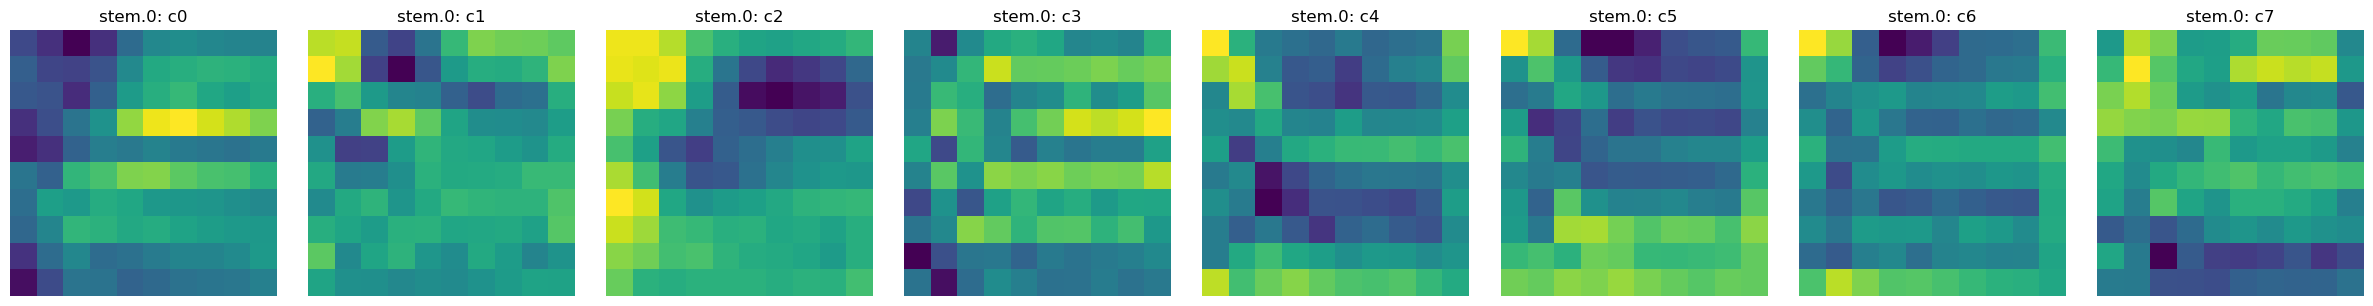

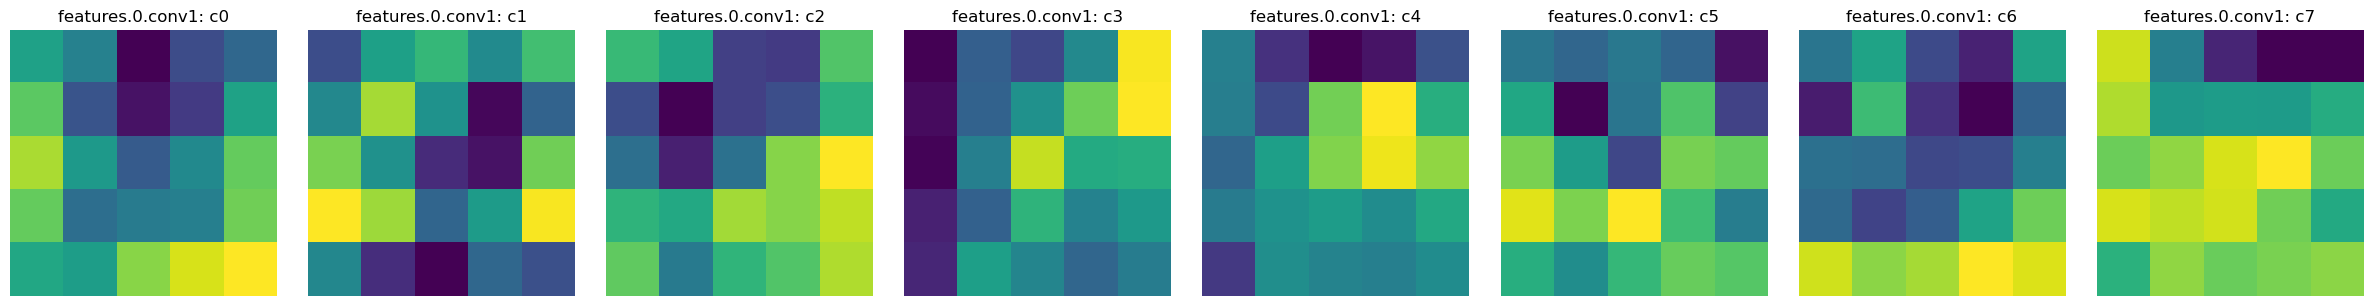

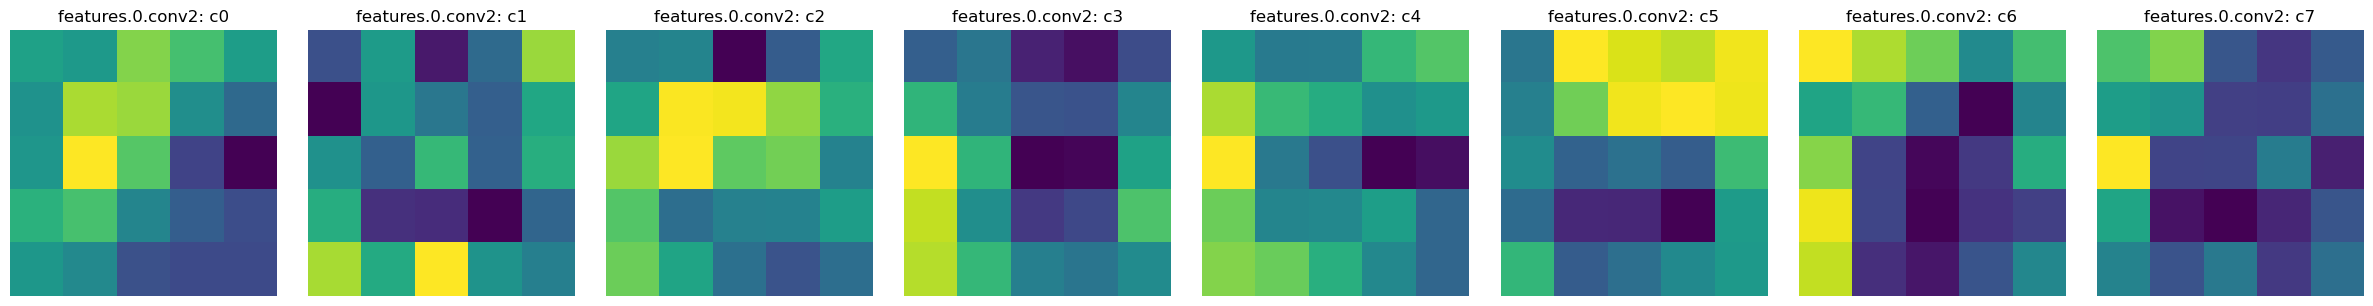

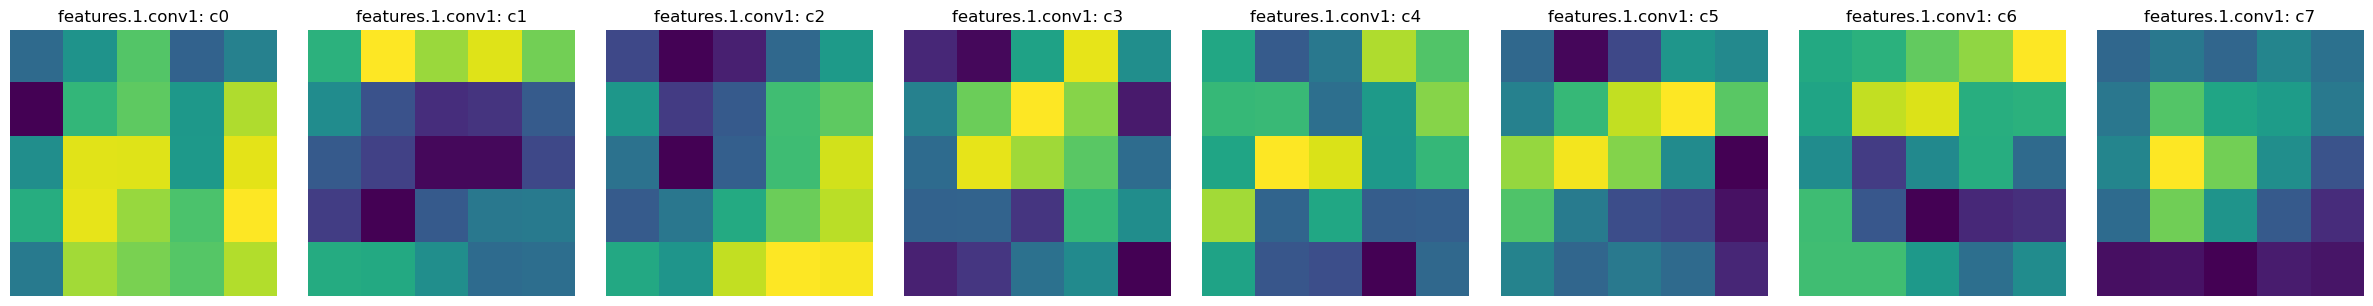

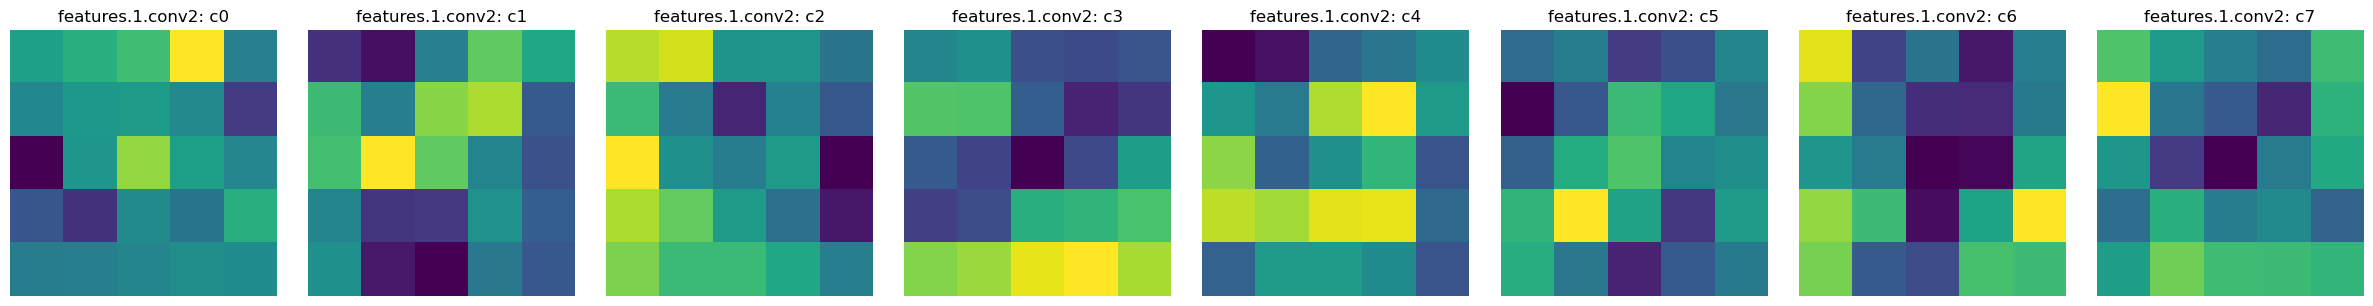

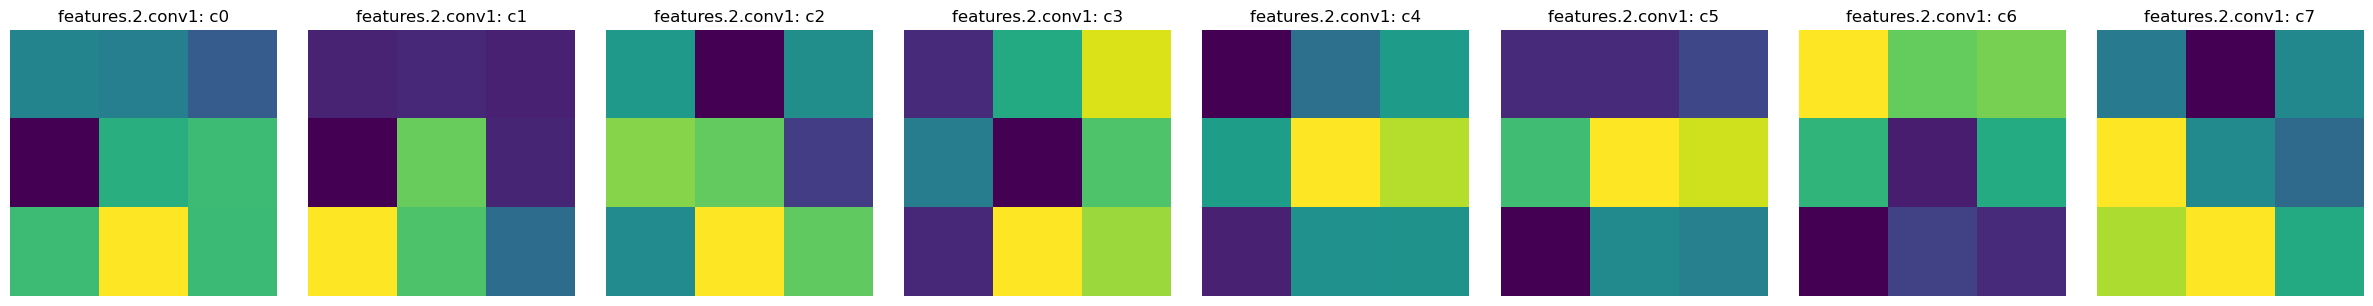

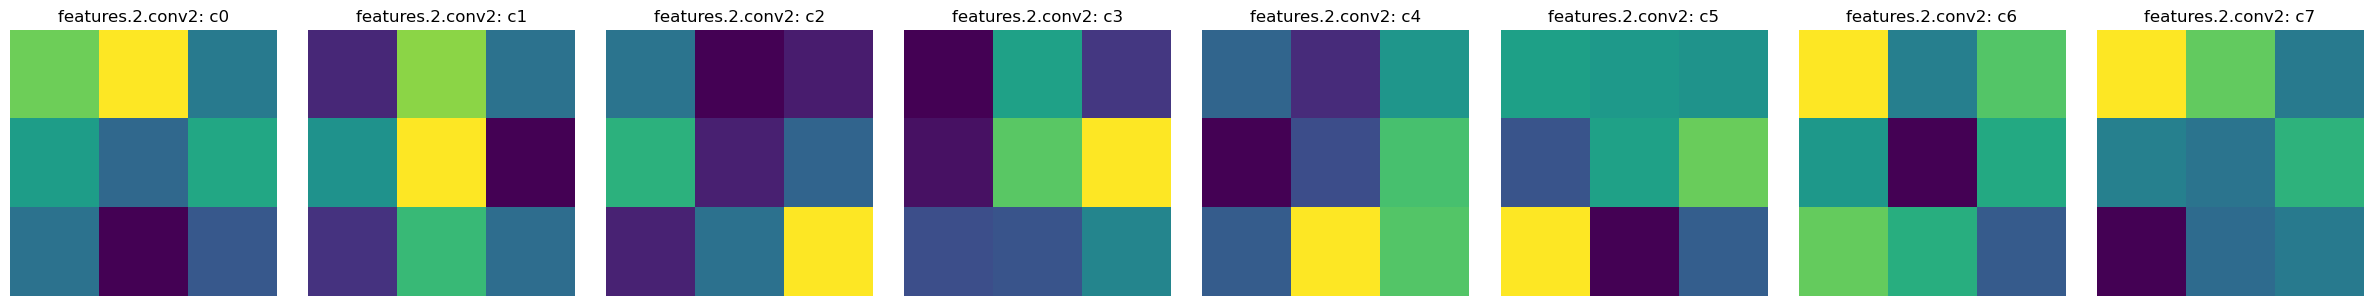

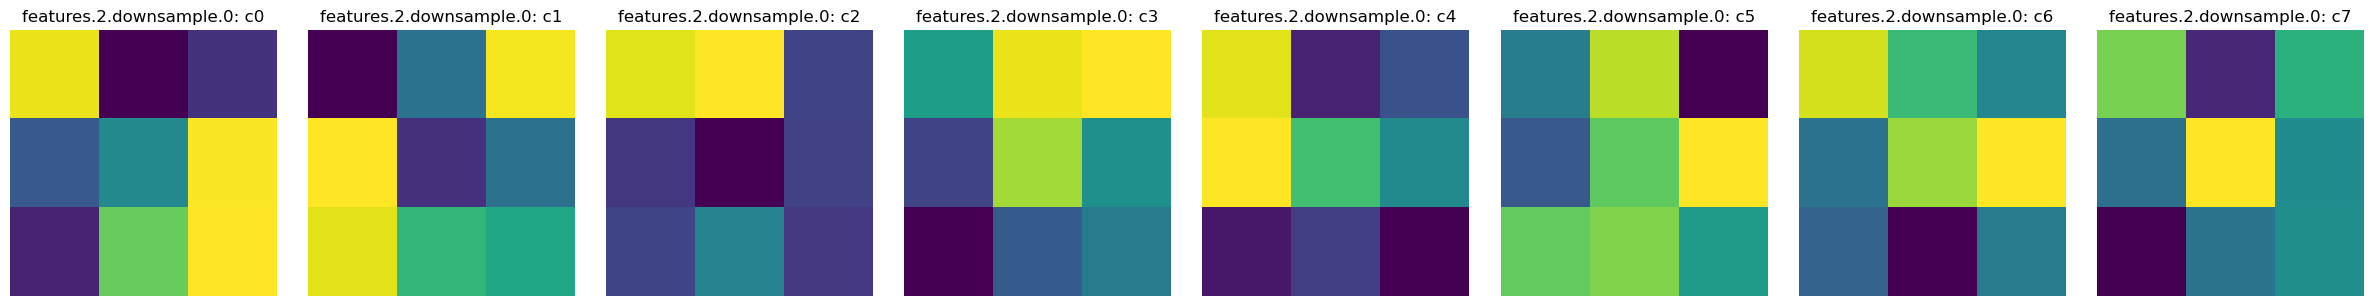

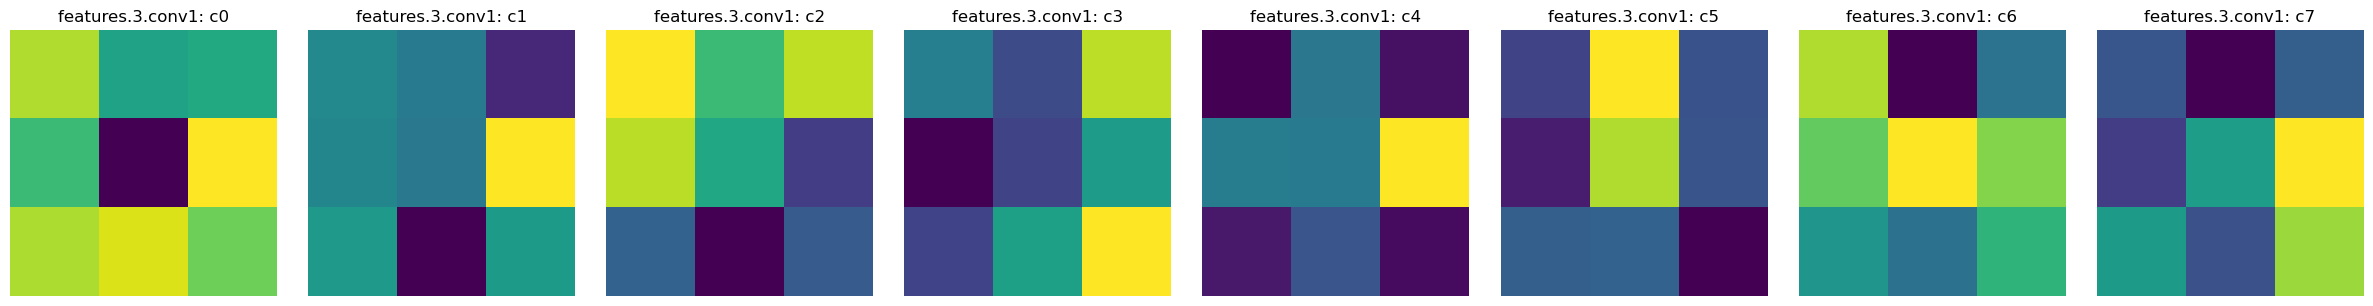

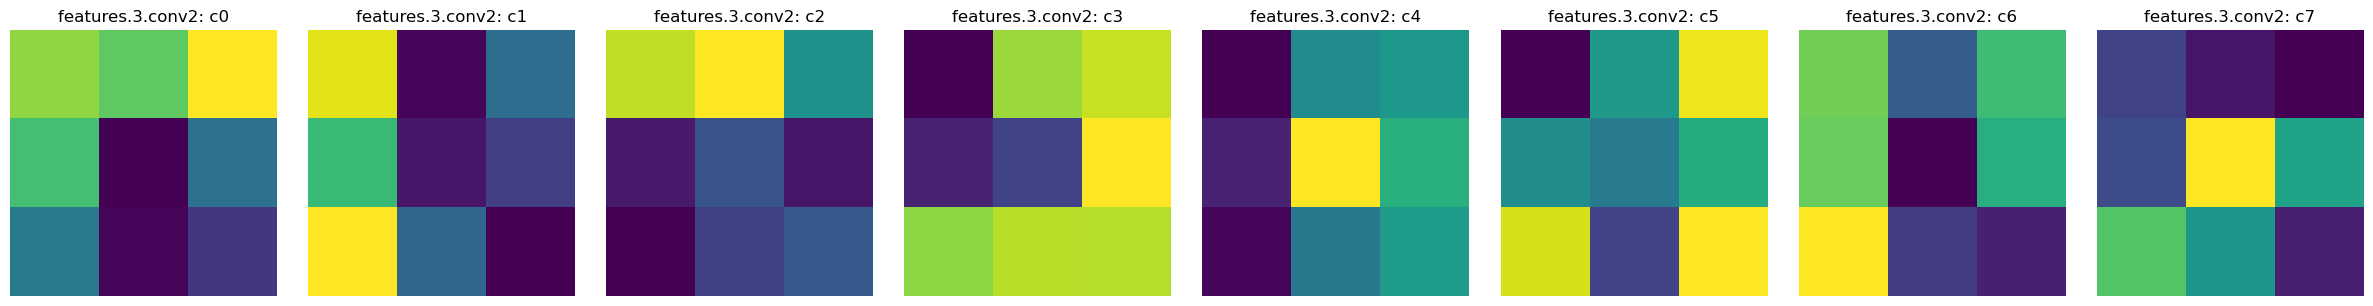

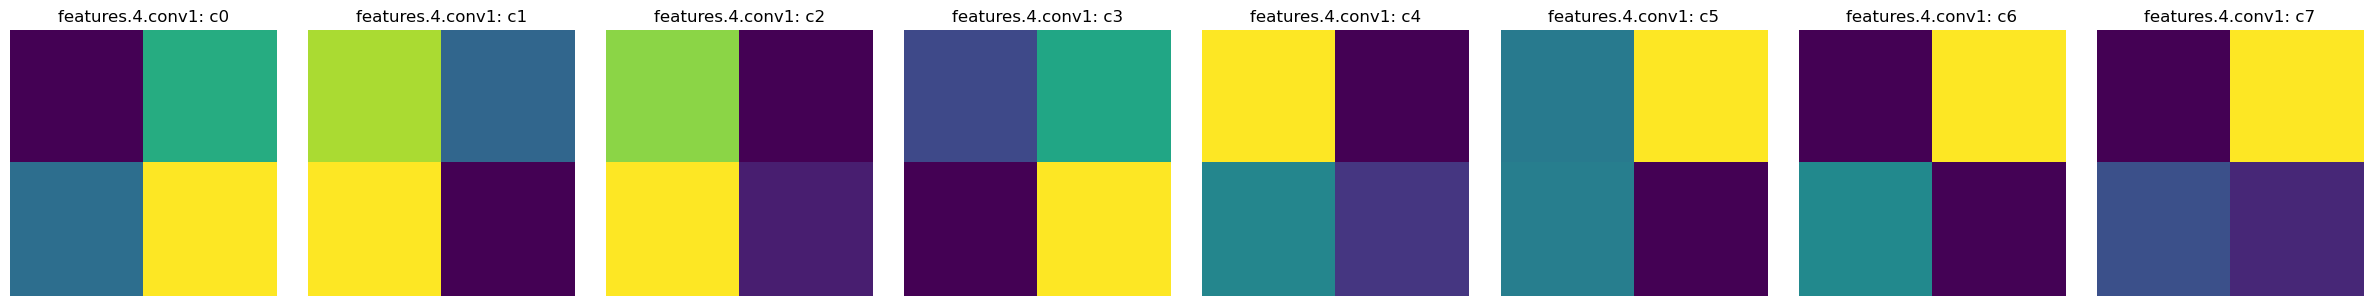

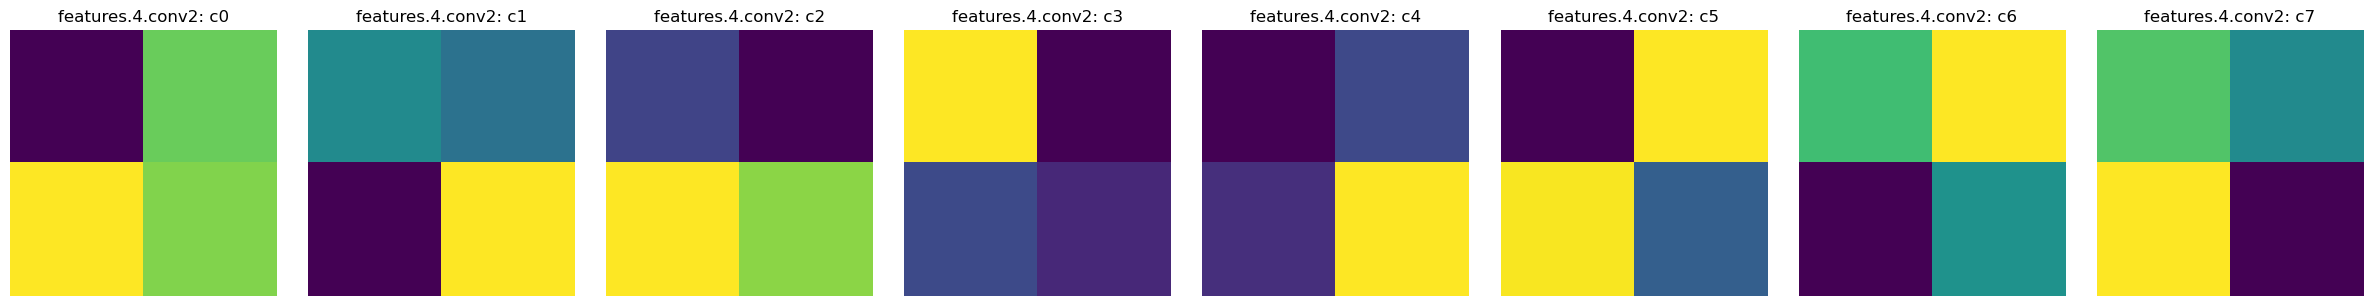

In [55]:
# Register hooks and capture activations
hooks, activations = register_activation_hooks(model, max_hooks=12)  # limit hooks to avoid huge visualizations

# Run a single sample through the network to capture activations
xb_vis, yb_vis = next(iter(dl_val))
xb_vis = xb_vis[:1].to(device)  # single sample
with torch.no_grad():
    _ = model(xb_vis)

# Visualize feature maps for captured layers
visualize_feature_maps(activations, sample_idx=0, max_channels=8)

# Optional: visualize pre-classifier embedding (post-pooling) if any activation has shape (C,1,1)
_ = plot_first_global_embedding(activations, save_dir=plot_dir)

# Interpreting neuron activations vs. input importance

This section adds quantitative input attributions so you can decide whether the model relies more on the closest or the furthest neighbors in the 2D neighbor-distance tensor.

Key ideas:
- Feature maps (from hooks) show internal activations but aren't directly attributable to specific input pixels.
- Saliency maps (gradient of the output logit w.r.t. the input) highlight which input pixels most influence the prediction.
- We'll aggregate saliency over the validation set, then summarize by neighbor rank (row/col). We'll also run a quick ablation: evaluate performance when keeping only the top-left k×k block (assumed closer neighbors by rank) vs only the bottom-right k×k (assumed furthest).

Assumption: indices along rows/cols are ordered by neighbor rank (small index = closer neighbor). If your tensor encodes a different ordering, adjust the masks accordingly.

In [56]:
# Ablation: keep-only closest vs keep-only furthest k×k blocks (by neighbor-rank indices)
from torch.utils.data import DataLoader

# Determine matrix size (H, W)
H = X_val_t.shape[-2]
W = X_val_t.shape[-1]
K = min(H, W)

def make_masked_copy(X4d, mode, k):
    """
    X4d: (N, 1, H, W) numpy array
    mode: 'closest-only' or 'furthest-only'
    k: block size
    """
    Xmasked = X4d.copy()
    if mode == 'closest-only':
        # Zero everything except top-left k×k block
        Xmasked[:, :, :k, k:] = 0
        Xmasked[:, :, k:, :] = 0
    elif mode == 'furthest-only':
        # Zero everything except bottom-right k×k block
        Xmasked[:, :, :-k, :] = 0
        Xmasked[:, :, :, :-k] = 0
    else:
        raise ValueError("Unknown mode")
    return Xmasked

# Evaluate AUC on validation for different k
ks = sorted({max(3, K//6), max(5, K//4), max(8, K//3), max(10, K//2), K})
print(f"Matrix size H×W = {H}×{W}; testing ks = {ks}")

results = []
for k in ks:
    for mode in ['closest-only', 'furthest-only']:
        X_val_mask = make_masked_copy(X_val_t, mode, k)
        ds_val_mask = GalaxyDataset(X_val_mask, y_val)
        dl_val_mask = DataLoader(ds_val_mask, batch_size=128, shuffle=False, num_workers=0)
        metrics = evaluate_model(model, dl_val_mask, device=device)
        results.append((mode, k, metrics['roc_auc'], metrics['balanced_accuracy']))
        print(f"{mode:14s} k={k:2d} | AUC={metrics['roc_auc']:.4f} | BalAcc={metrics['balanced_accuracy']:.4f}")

# Simple recommendation based on best AUC among tested modes/ks
best = max(results, key=lambda t: t[2]) if results else None
if best:
    mode, k, auc, bal = best
    print(f"\nBest among tested masks: {mode} with k={k} | AUC={auc:.4f} | BalAcc={bal:.4f}")
    print("Interpretation guide:")
    print("- If 'closest-only' wins with moderate k, the model mainly uses closer neighbors -> you can reduce tensor size.")
    print("- If 'furthest-only' or large k wins, the model benefits from including more distant neighbors -> keep or increase size.")
else:
    print("No ablation results produced.")

Matrix size H×W = 20×20; testing ks = [3, 5, 8, 10, 20]
closest-only   k= 3 | AUC=0.4533 | BalAcc=0.4717
furthest-only  k= 3 | AUC=0.5728 | BalAcc=0.5234
closest-only   k= 5 | AUC=0.4576 | BalAcc=0.4905
furthest-only  k= 5 | AUC=0.5291 | BalAcc=0.5181
closest-only   k= 8 | AUC=0.3917 | BalAcc=0.4735
furthest-only  k= 8 | AUC=0.6222 | BalAcc=0.5975
closest-only   k=10 | AUC=0.4537 | BalAcc=0.4748
furthest-only  k=10 | AUC=0.6785 | BalAcc=0.6401
closest-only   k=20 | AUC=0.7561 | BalAcc=0.6763
furthest-only  k=20 | AUC=0.7561 | BalAcc=0.6763

Best among tested masks: closest-only with k=20 | AUC=0.7561 | BalAcc=0.6763
Interpretation guide:
- If 'closest-only' wins with moderate k, the model mainly uses closer neighbors -> you can reduce tensor size.
- If 'furthest-only' or large k wins, the model benefits from including more distant neighbors -> keep or increase size.


In [57]:
# Rectangular ablation and cropping evaluations
import numpy as np
from torch.utils.data import DataLoader

H = X_val_t.shape[-2]
W = X_val_t.shape[-1]
K = min(H, W)

def mask_rows_furthest(X4d, k):
    Xmasked = X4d.copy()
    # keep last k rows, zero others
    if k < H:
        Xmasked[:, :, :-k, :] = 0
    return Xmasked

def mask_cols_furthest(X4d, k):
    Xmasked = X4d.copy()
    # keep last k cols, zero others
    if k < W:
        Xmasked[:, :, :, :-k] = 0
    return Xmasked

# Choose k values to test; include 10 to answer your question directly
k_list = [6, 8, 10, 12]
print(f"Rectangular tests on rows/cols furthest k, k_list={k_list}, H×W={H}×{W}")

for k in k_list:
    # Masking (preserve 20×20)
    X_val_rows_mask = mask_rows_furthest(X_val_t, k)
    dl_rows_mask = DataLoader(GalaxyDataset(X_val_rows_mask, y_val), batch_size=128, shuffle=False, num_workers=0)
    metrics_rows_mask = evaluate_model(model, dl_rows_mask, device=device)

    X_val_cols_mask = mask_cols_furthest(X_val_t, k)
    dl_cols_mask = DataLoader(GalaxyDataset(X_val_cols_mask, y_val), batch_size=128, shuffle=False, num_workers=0)
    metrics_cols_mask = evaluate_model(model, dl_cols_mask, device=device)

    print(f"[Mask] rows-furthest k={k:2d} | AUC={metrics_rows_mask['roc_auc']:.4f} | BalAcc={metrics_rows_mask['balanced_accuracy']:.4f}")
    print(f"[Mask] cols-furthest k={k:2d} | AUC={metrics_cols_mask['roc_auc']:.4f} | BalAcc={metrics_cols_mask['balanced_accuracy']:.4f}")

    # Cropping (actual k×20 or 20×k)
    X_val_rows_crop = X_val_t[:, :, -k:, :]  # (N,1,k,20)
    dl_rows_crop = DataLoader(GalaxyDataset(X_val_rows_crop, y_val), batch_size=128, shuffle=False, num_workers=0)
    metrics_rows_crop = evaluate_model(model, dl_rows_crop, device=device)

    X_val_cols_crop = X_val_t[:, :, :, -k:]  # (N,1,20,k)
    dl_cols_crop = DataLoader(GalaxyDataset(X_val_cols_crop, y_val), batch_size=128, shuffle=False, num_workers=0)
    metrics_cols_crop = evaluate_model(model, dl_cols_crop, device=device)

    print(f"[Crop] rows-furthest k={k:2d} (k×{W}) | AUC={metrics_rows_crop['roc_auc']:.4f} | BalAcc={metrics_rows_crop['balanced_accuracy']:.4f}")
    print(f"[Crop] cols-furthest k={k:2d} ({H}×k) | AUC={metrics_cols_crop['roc_auc']:.4f} | BalAcc={metrics_cols_crop['balanced_accuracy']:.4f}")

print("\nNote: Masking keeps 20×20 with zeros; cropping changes spatial size. If a cropped k performs close to full size, you can retrain on that rectangular size for best results.")

Rectangular tests on rows/cols furthest k, k_list=[6, 8, 10, 12], H×W=20×20
[Mask] rows-furthest k= 6 | AUC=0.6459 | BalAcc=0.5493
[Mask] cols-furthest k= 6 | AUC=0.6027 | BalAcc=0.5329
[Crop] rows-furthest k= 6 (k×20) | AUC=0.6437 | BalAcc=0.5551
[Crop] cols-furthest k= 6 (20×k) | AUC=0.2951 | BalAcc=0.4099
[Mask] rows-furthest k= 8 | AUC=0.6967 | BalAcc=0.6393
[Mask] cols-furthest k= 8 | AUC=0.6135 | BalAcc=0.5434
[Crop] rows-furthest k= 8 (k×20) | AUC=0.6375 | BalAcc=0.5522
[Crop] cols-furthest k= 8 (20×k) | AUC=0.3019 | BalAcc=0.4069
[Mask] rows-furthest k=10 | AUC=0.7170 | BalAcc=0.6580
[Mask] cols-furthest k=10 | AUC=0.6243 | BalAcc=0.5580
[Crop] rows-furthest k=10 (k×20) | AUC=0.6716 | BalAcc=0.5879
[Crop] cols-furthest k=10 (20×k) | AUC=0.3697 | BalAcc=0.4430
[Mask] rows-furthest k=12 | AUC=0.6882 | BalAcc=0.6327
[Mask] cols-furthest k=12 | AUC=0.6222 | BalAcc=0.5678
[Crop] rows-furthest k=12 (k×20) | AUC=0.6837 | BalAcc=0.5888
[Crop] cols-furthest k=12 (20×k) | AUC=0.3778 | Ba

# Rectangular ablation/cropping: test 10×20 or 20×10 without retraining

We test two scenarios:
- Keep only the furthest k rows and all columns (k×20). With k=10, this mimics “10 furthest neighbors × 20 columns”.
- Keep only the furthest k columns and all rows (20×k). With k=10, this mimics “20 rows × 10 furthest columns”.

We report two variants:
- Masking: zero out the rest while preserving 20×20 shape (same normalization stats, quick diagnostic).
- Cropping: actually pass a k×20 (or 20×k) tensor to the model. Convs + global pooling allow variable H×W at inference, but note the model was trained on 20×20, so retraining on the chosen size is recommended once you decide.

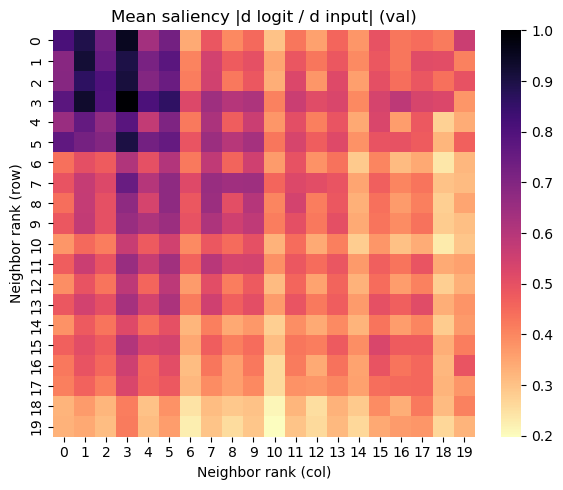

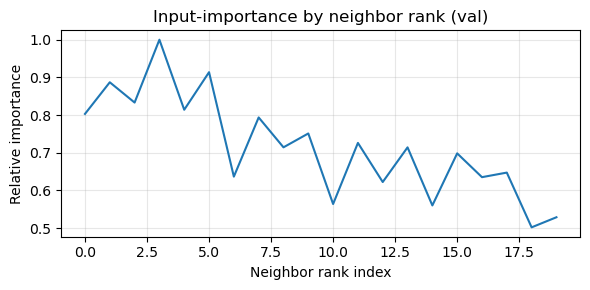

Saliency mass (top-left k×k = 4): 13.4381
Saliency mass (bottom-right k×k = 4): 6.1033
Fraction in closest block vs furthest block: 0.688


In [58]:
# Saliency map: mean |d logit / d input| over validation set
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()

@torch.no_grad()
def _get_logits(x):
    out = model(x)
    # Ensure logits shape (B,) for convenience
    if out.ndim == 2 and out.shape[1] == 1:
        out = out[:, 0]
    return out

def compute_mean_saliency(model, dataloader, device, max_batches=10):
    model.train()  # enable grad; we'll switch off no_grad below
    total_sal = None
    total_count = 0
    batches = 0

    for i, (xb, yb) in enumerate(dataloader):
        if i >= max_batches:
            break
        xb = xb.to(device)
        xb.requires_grad_(True)

        model.zero_grad(set_to_none=True)
        logits = model(xb)
        if logits.ndim == 2 and logits.shape[1] == 1:
            logits = logits[:, 0]
        # Take gradient of the positive-class logit sum w.r.t. input
        grad = torch.autograd.grad(logits.sum(), xb, retain_graph=False)[0]
        sal = grad.abs()  # (B, 1, H, W)

        # Sum over batch for proper weighting
        bsz = sal.shape[0]
        sal_sum = sal.sum(dim=0)  # (1, H, W)
        sal_sum = sal_sum.squeeze(0)  # (H, W)

        if total_sal is None:
            total_sal = sal_sum.detach().cpu()
        else:
            total_sal += sal_sum.detach().cpu()
        total_count += bsz
        batches += 1

    if total_sal is None:
        return None

    mean_sal = (total_sal / max(total_count, 1)).numpy()  # (H, W)
    # Normalize for visualization
    vmax = mean_sal.max() if np.isfinite(mean_sal).any() else 1.0
    if vmax > 0:
        mean_sal = mean_sal / vmax
    return mean_sal

# Compute mean saliency on a few validation batches for speed
mean_sal_val = compute_mean_saliency(model, dl_val, device=device, max_batches=10)

# Visualize the heatmap
if mean_sal_val is not None:
    H, W = mean_sal_val.shape
    plt.figure(figsize=(6, 5))
    sns.heatmap(mean_sal_val, cmap="magma_r")
    plt.title("Mean saliency |d logit / d input| (val)")
    plt.xlabel("Neighbor rank (col)")
    plt.ylabel("Neighbor rank (row)")
    plt.tight_layout()
    plt.show()

    # Summaries by rank (row/col)
    row_importance = mean_sal_val.sum(axis=1)
    col_importance = mean_sal_val.sum(axis=0)
    # Combine to a single neighbor-rank score (assuming same ordering on rows/cols)
    rank_importance = (row_importance + col_importance) / 2.0

    plt.figure(figsize=(6, 3))
    plt.plot(np.arange(len(rank_importance)), rank_importance / (rank_importance.max() + 1e-12), label="Rank importance")
    plt.xlabel("Neighbor rank index")
    plt.ylabel("Relative importance")
    plt.title("Input-importance by neighbor rank (val)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Closest-vs-furthest quick score
    K = min(H, W)
    k = max(3, K // 5)  # use top ~20% (at least 3)
    top_left_mass = mean_sal_val[:k, :k].sum()
    bottom_right_mass = mean_sal_val[-k:, -k:].sum()
    print(f"Saliency mass (top-left k×k = {k}): {top_left_mass:.4f}")
    print(f"Saliency mass (bottom-right k×k = {k}): {bottom_right_mass:.4f}")
    if top_left_mass + bottom_right_mass > 0:
        ratio = top_left_mass / (top_left_mass + bottom_right_mass)
        print(f"Fraction in closest block vs furthest block: {ratio:.3f}")
else:
    print("No saliency computed (dl_val empty?).")

In [59]:
# requires mean_sal_val computed already
topk = 10
row_imp = mean_sal_val.sum(axis=1)   # shape (H,)
col_imp = mean_sal_val.sum(axis=0)   # shape (W,)
row_top_mass = row_imp[-topk:].sum()
col_top_mass = col_imp[-topk:].sum()
print("Row top-10 mass:", row_top_mass, "Fraction:", row_top_mass / row_imp.sum())
print("Col top-10 mass:", col_top_mass, "Fraction:", col_top_mass / col_imp.sum())

Row top-10 mass: 81.74451 Fraction: 0.43579364
Col top-10 mass: 80.346855 Fraction: 0.42834255


In [60]:
from torch.utils.data import DataLoader

# 10×20 (last 10 rows, all columns)
X_rows_crop = X_val_t[:, :, -10:, :]        # (N,1,10,20)
dl_rows_crop = DataLoader(GalaxyDataset(X_rows_crop, y_val), batch_size=128, shuffle=False)
metrics_rows_crop = evaluate_model(model, dl_rows_crop, device=device)
print("10x20 | AUC:", metrics_rows_crop['roc_auc'], "BalAcc:", metrics_rows_crop['balanced_accuracy'])

# 20×10 (all rows, last 10 cols)
X_cols_crop = X_val_t[:, :, :, -10:]        # (N,1,20,10)
dl_cols_crop = DataLoader(GalaxyDataset(X_cols_crop, y_val), batch_size=128, shuffle=False)
metrics_cols_crop = evaluate_model(model, dl_cols_crop, device=device)
print("20x10 | AUC:", metrics_cols_crop['roc_auc'], "BalAcc:", metrics_cols_crop['balanced_accuracy'])

10x20 | AUC: 0.6678126733321423 BalAcc: 0.5951531269850152
20x10 | AUC: 0.379723502088356 BalAcc: 0.45304307147892686


In [61]:
# Compact comparison helper (run after the previous cell)
def _fmt(m):
    return f"AUC={m['roc_auc']:.4f} | BalAcc={m['balanced_accuracy']:.4f}"

print("10x20:", _fmt(metrics_rows_crop))
print("20x10:", _fmt(metrics_cols_crop))

# Simple winner decision with small tie tolerance
tol = 0.002
auc_diff = metrics_rows_crop['roc_auc'] - metrics_cols_crop['roc_auc']
bal_diff = metrics_rows_crop['balanced_accuracy'] - metrics_cols_crop['balanced_accuracy']
if abs(auc_diff) <= tol and abs(bal_diff) <= tol:
    print(f"Winner: tie (|ΔAUC|<= {tol}, |ΔBalAcc|<= {tol})")
elif (auc_diff > tol) or (auc_diff >= -tol and bal_diff > tol):
    print("Winner: 10x20 (rows-furthest 10 × all columns)")
else:
    print("Winner: 20x10 (all rows × cols-furthest 10)")

10x20: AUC=0.6678 | BalAcc=0.5952
20x10: AUC=0.3797 | BalAcc=0.4530
Winner: 10x20 (rows-furthest 10 × all columns)


# Plot training curves

Saved training/validation loss plot to /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/training_validation_loss.png


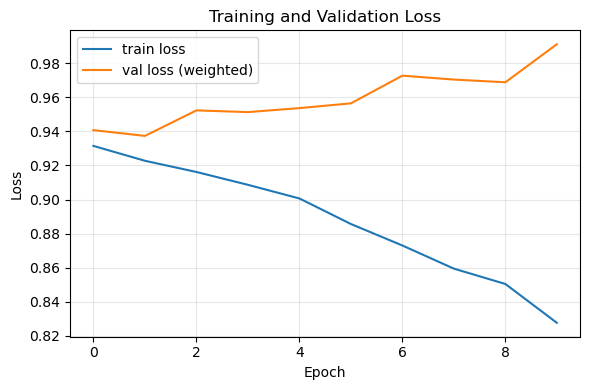

In [62]:
# Plot training curves using library helper
# plot_training_and_validation_loss(history, include_val_bce=True, save_dir=plot_dir)

plot_training_and_validation_loss(history, include_val_bce=False, save_dir=plot_dir)

In [63]:
# Derive threshold on validation by maximizing TSS, then apply on test
val_metrics = evaluate_model(model, dl_val, device=device)
fpr_v, tpr_v, thr_v = roc_curve(val_metrics['targets'], val_metrics['probs'])
tss_v = tpr_v - fpr_v
best_idx = int(np.argmax(tss_v)) if len(tss_v) else 0
best_thr = thr_v[best_idx] if len(thr_v) else 0.5
print(f"Selected threshold from validation (max TSS): {best_thr:.4f} | TSS_val_max={tss_v[best_idx]:.4f}")

# Evaluate test at fixed threshold
test_probs = evaluate_model(model, dl_test, device=device)['probs']
test_preds_thr = (test_probs >= best_thr).astype(int)
test_targets = evaluate_model(model, dl_test, device=device)['targets']
cm_thr = confusion_matrix(test_targets, test_preds_thr, labels=[0,1])
tn, fp, fn, tp = cm_thr.ravel() if cm_thr.size==4 else (0,0,0,0)
tpr = tp / (tp + fn) if (tp+fn)>0 else 0.0
fpr = fp / (fp + tn) if (fp+tn)>0 else 0.0
tss_fixed = tpr - fpr
bal_acc_fixed = ( (tp/(tp+fn) if (tp+fn)>0 else 0) + (tn/(tn+fp) if (tn+fp)>0 else 0) ) / 2.0
mcc_num = (tp*tn - fp*fn)
mcc_den = np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
mcc_fixed = (mcc_num / mcc_den) if mcc_den>0 else 0.0
print(f"Fixed-threshold@valTSS | thr={best_thr:.4f} | TPR={tpr:.3f} | FPR={fpr:.3f} | TSS={tss_fixed:.3f} | BalAcc={bal_acc_fixed:.3f} | MCC={mcc_fixed:.3f}")

Selected threshold from validation (max TSS): 0.5128 | TSS_val_max=0.3551
Fixed-threshold@valTSS | thr=0.5128 | TPR=0.679 | FPR=0.279 | TSS=0.400 | BalAcc=0.700 | MCC=0.307


# Evaluate on test set

Saved confusion matrix to /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/confusion_matrix_basic.png


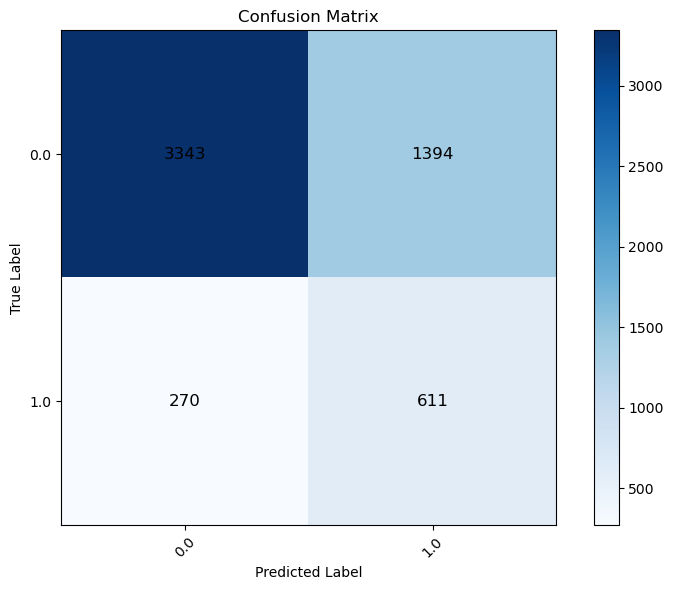

Saved ROC curve to /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/roc_curve.png


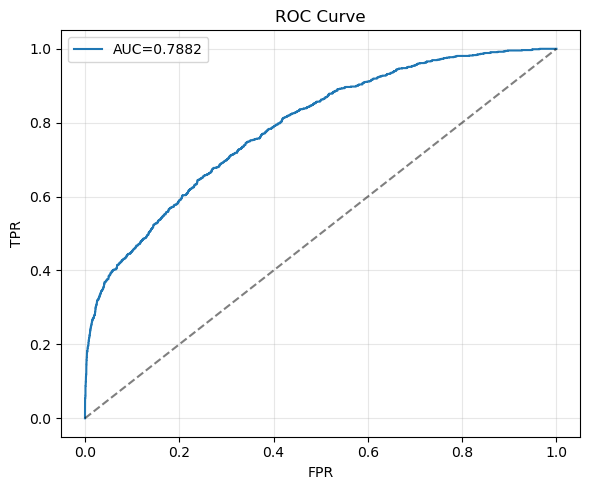

In [64]:
test_metrics = evaluate_model(model, dl_test, device=device)
class_labels = np.unique(np.concatenate((test_metrics['targets'], test_metrics['preds'])))

# Compute the confusion matrix
cm = confusion_matrix(test_metrics['targets'], test_metrics['preds'], labels=class_labels)

plot_confusion_matrix_basic(cm, class_labels, title='Confusion Matrix', save_dir=plot_dir)

# ROC curve
fpr, tpr, thr = roc_curve(test_metrics['targets'], test_metrics['probs'])
plot_roc_curve(fpr, tpr, test_metrics['roc_auc'], save_dir=plot_dir)

Saved true/false positive distribution plot to /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/true_false_positive_distribution.png


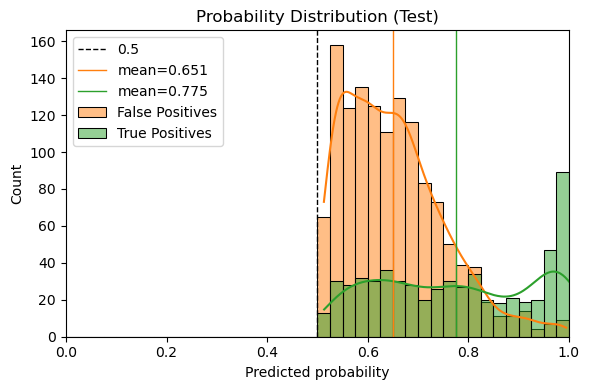

FP count=1321 | mean=0.651 | median=0.637 | >0.9: 2.57% | 0.5–0.7: 72.90%
TP count=598 | mean=0.775 | median=0.773 | >0.9: 29.26% | 0.5–0.7: 37.96%
Saved true/false negative distribution plot to /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/true_false_negative_distribution.png


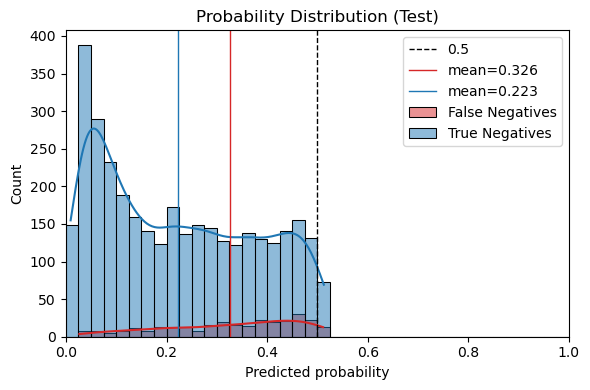

FN count=283 | mean=0.326 | median=0.349 | <0.1: 7.07% | 0.3–0.5: 57.60%
TN count=3416 | mean=0.223 | median=0.204 | <0.1: 31.00% | 0.3–0.5: 31.29%


In [65]:
true_false_positive_negative(test_preds_thr=test_preds_thr, test_targets=test_targets, test_probs=test_probs, save_dir=plot_dir)

In [66]:
# Print robust, prior-insensitive metrics
print(
    " | ".join([
        f"AUC: {test_metrics['roc_auc']:.4f}",
        f"BalancedAcc: {test_metrics['balanced_accuracy']:.4f}",
        f"MCC: {test_metrics['mcc']:.4f}",
        f"TSSmax: {test_metrics['tss_max']:.4f}",
        f"BrierSkill: {test_metrics['brier_skill']:.4f}",
        f"LogLossSkill: {test_metrics['log_loss_skill']:.4f}"
    ])
)

AUC: 0.7882 | BalancedAcc: 0.6996 | MCC: 0.3030 | TSSmax: 0.4060 | BrierSkill: -0.3474 | LogLossSkill: -0.2027


Saved reliability diagram to /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/reliability_diagram.png


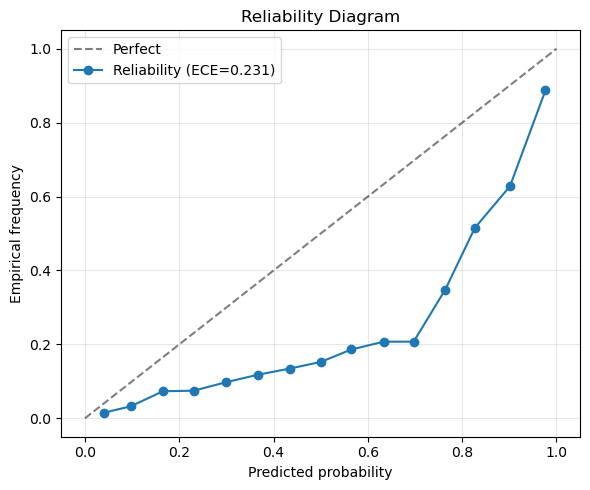

In [67]:
# Reliability diagram (calibration) and ECE using library helpers
ece, prob_true, prob_pred = expected_calibration_error(test_metrics['targets'], test_metrics['probs'], n_bins=15)
plot_reliability_diagram(prob_pred, prob_true, ece, save_dir=plot_dir)

Saved confusion matrices to /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/confusion_matrix_row_normalized.png


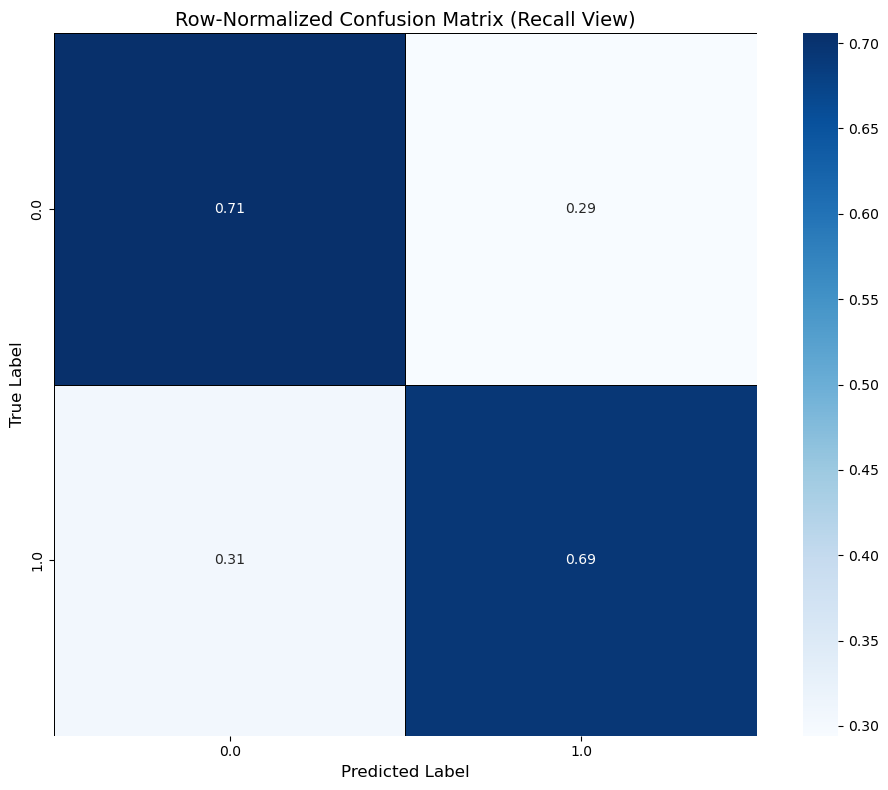

Saved confusion matrices to /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/confusion_matrix_column_normalized.png


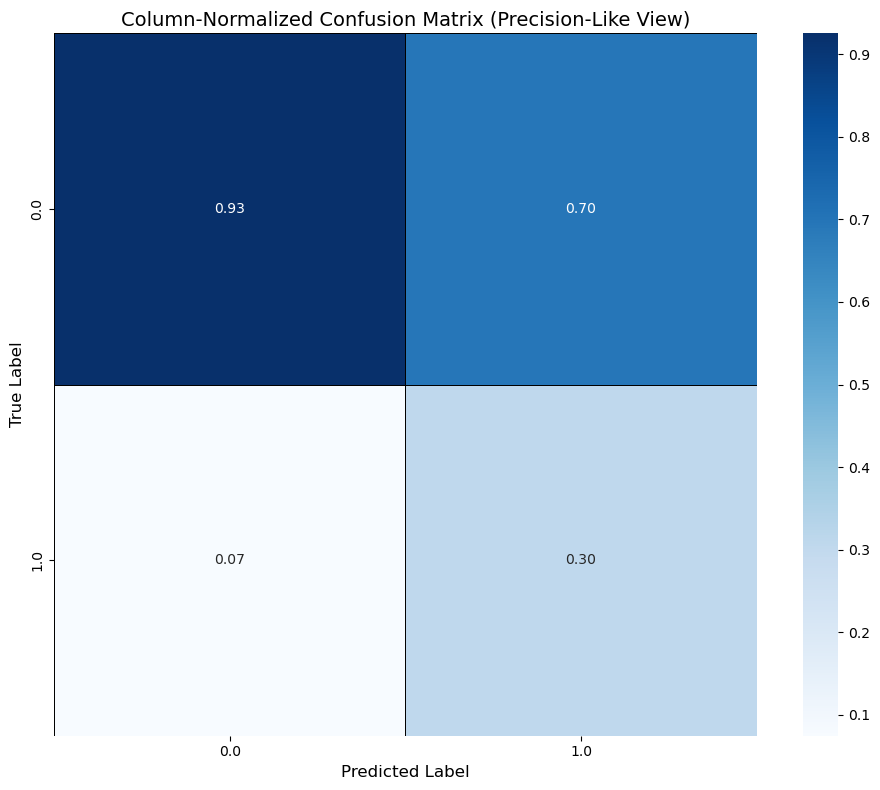

Saved confusion matrices to /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/confusion_matrix_global_normalized.png


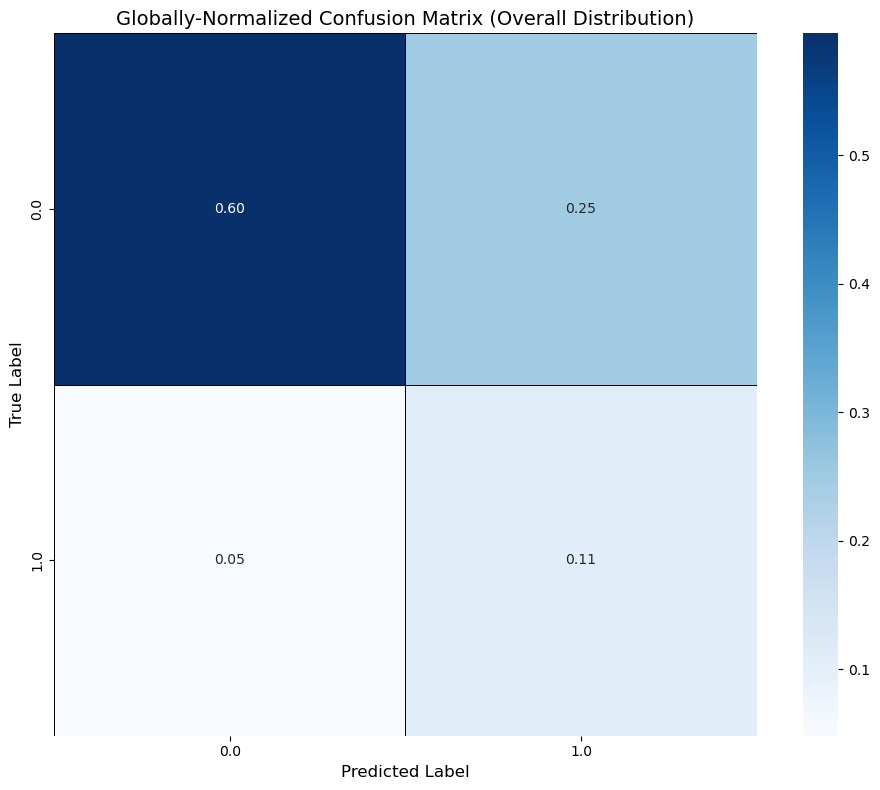

In [68]:
# Confusion matrices: row/column/global normalized views
plot_confusion_matrices_all_views(cm, class_labels, save_dir=plot_dir)

Saved precision-recall curve to /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/precision_recall_curve.png


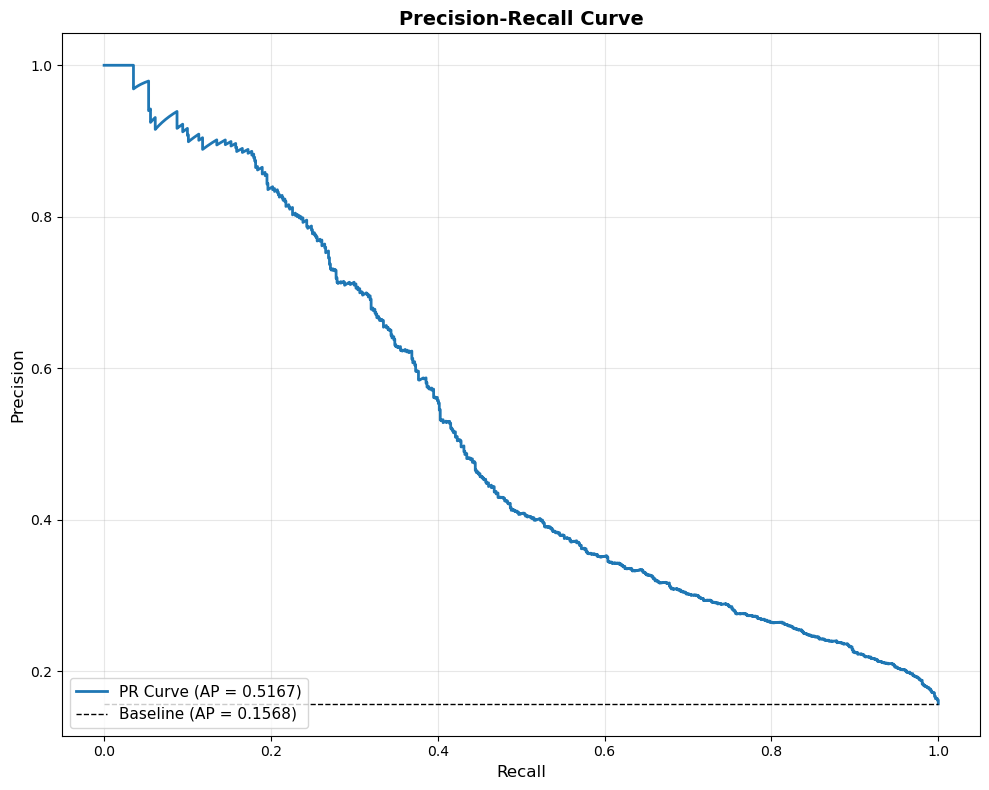

Saved prediction distribution plot to /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/prediction_distribution.png


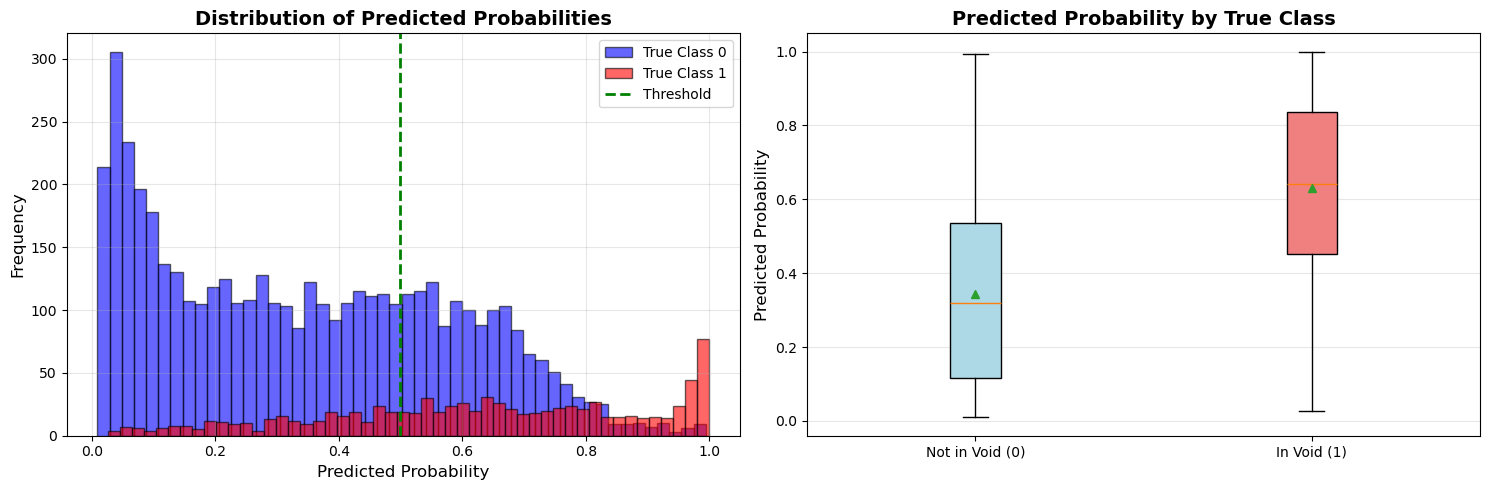

Saved threshold analysis plot to /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/plot/threshold_analysis.png


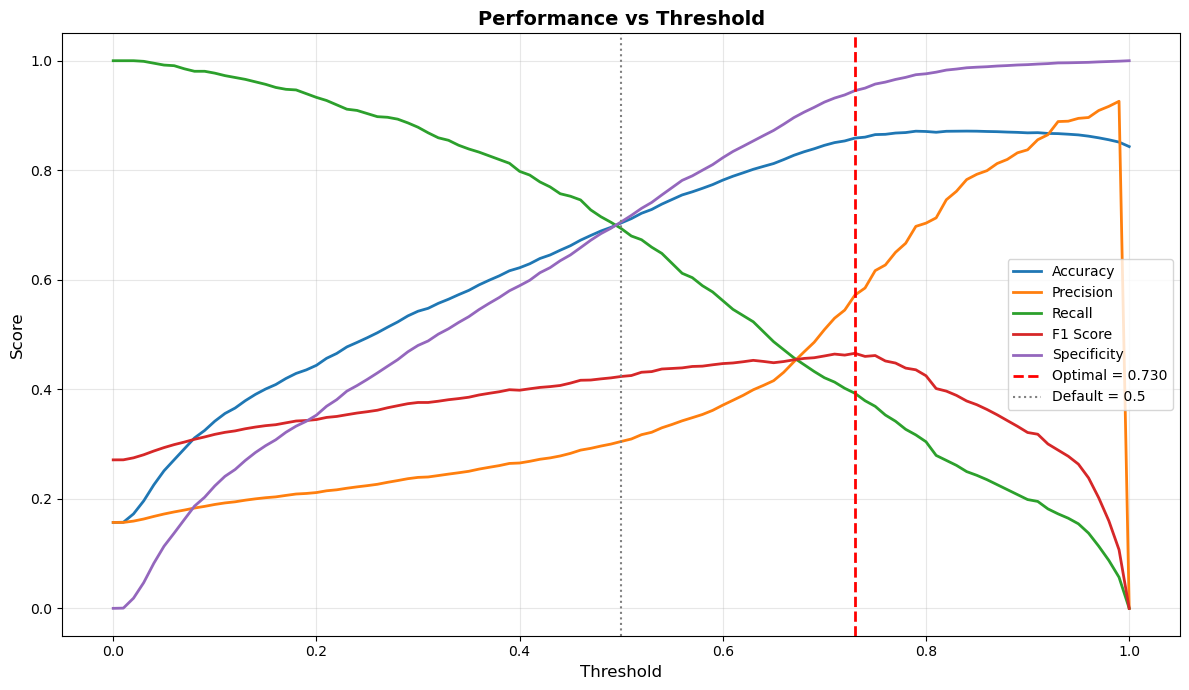


=== Optimal Threshold: 0.730 ===
F1 Score: 0.4657


0.73

In [69]:
# Use plotting utilities from the library module
plot_precision_recall_curve(test_metrics['targets'], test_metrics['probs'], save_dir=plot_dir)
plot_prediction_distribution(test_metrics['targets'], test_metrics['probs'], save_dir=plot_dir)
plot_threshold_analysis(test_metrics['targets'], test_metrics['probs'], save_dir=plot_dir)

In [70]:
# Save key metrics to JSON for later comparison
metrics_to_save = {
    'auc': float(test_metrics['roc_auc']),
    'balanced_accuracy': float(test_metrics['balanced_accuracy']),
    'mcc': float(test_metrics['mcc']),
    'tss_max': float(test_metrics['tss_max']),
    'brier_skill': float(test_metrics['brier_skill']),
    'log_loss_skill': float(test_metrics['log_loss_skill']),
    'val_tss_threshold': float(best_thr),
    'fixed_thr_tss': float(tss_fixed),
    'fixed_thr_bal_acc': float(bal_acc_fixed),
    'fixed_thr_mcc': float(mcc_fixed),
    # 'ap': float(ap),
    'ece': float(ece),
}

metrics_path = result_dir / f'metrics_{name}.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics_to_save, f, indent=2)
print(f'Saved metrics to {metrics_path}')

Saved metrics to /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/simulation_box2/default/result/metrics_simulation_box2.json
